## Assignment: Clustering

### Import all the libraries

In [0]:
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, SpectralClustering
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import scale
from time import time
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt

### Section A: Know Your Data

In [3]:
#Load the digits dataset 
digits = load_digits()
digits_data, digits_labels = digits.data, digits.target

#Scale the dataset
digits_data = scale(digits_data)

n_samples, n_features = digits_data.shape
n_digits = len(np.unique(digits.target))

#Get a 2D PCA reduced representation
pdigits_data = scale(PCA(n_components= 2).fit_transform(digits_data))

#Get a 2D t-SNE reduced representation
tdigits_data = scale(TSNE(n_components=2).fit_transform(digits_data))

print("Number of digits: ",n_digits,", Number of samples: ",n_samples,", Dimensions: ",n_features)
print("Vector representing the first digit datapoint:\n",digits.data[0])

Number of digits:  10 , Number of samples:  1797 , Dimensions:  64
Vector representing the first digit datapoint:
 [ 0.  0.  5. 13.  9.  1.  0.  0.  0.  0. 13. 15. 10. 15.  5.  0.  0.  3.
 15.  2.  0. 11.  8.  0.  0.  4. 12.  0.  0.  8.  8.  0.  0.  5.  8.  0.
  0.  9.  8.  0.  0.  4. 11.  0.  1. 12.  7.  0.  0.  2. 14.  5. 10. 12.
  0.  0.  0.  0.  6. 13. 10.  0.  0.  0.]


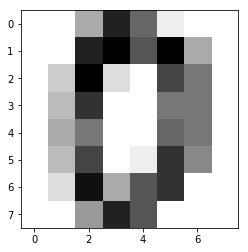

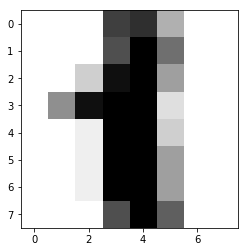

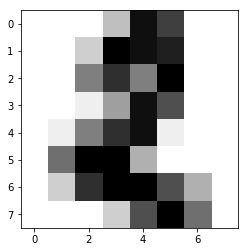

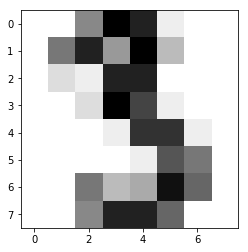

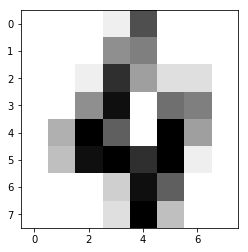

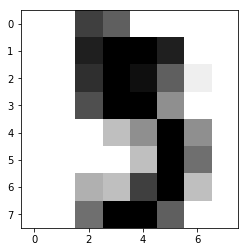

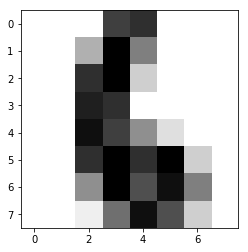

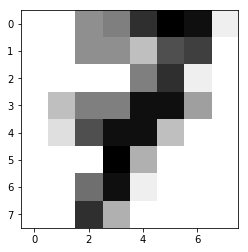

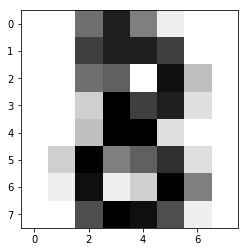

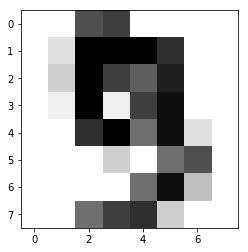

(1797, 8, 8)

In [4]:
#Plot the first 10 digits in the digits dataset
for i in range(0,10):
  plt.imshow(digits.images[i], cmap=plt.cm.gray_r, interpolation='nearest')
  plt.show()
np.shape(digits.images)

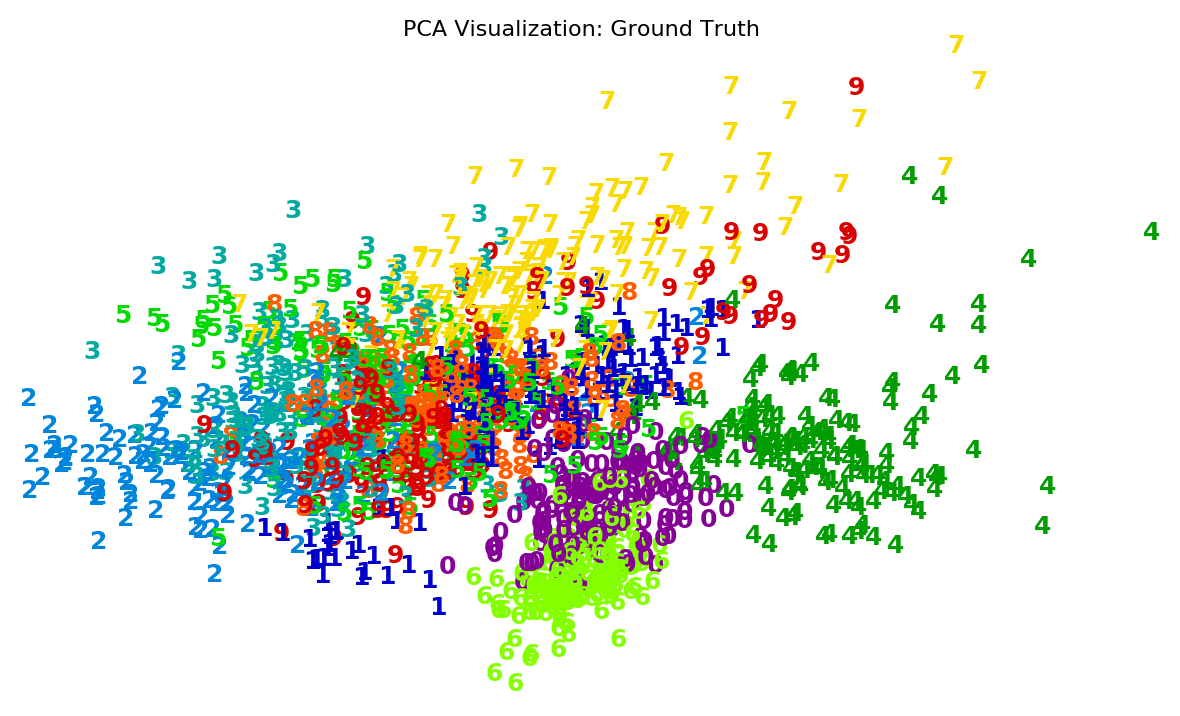

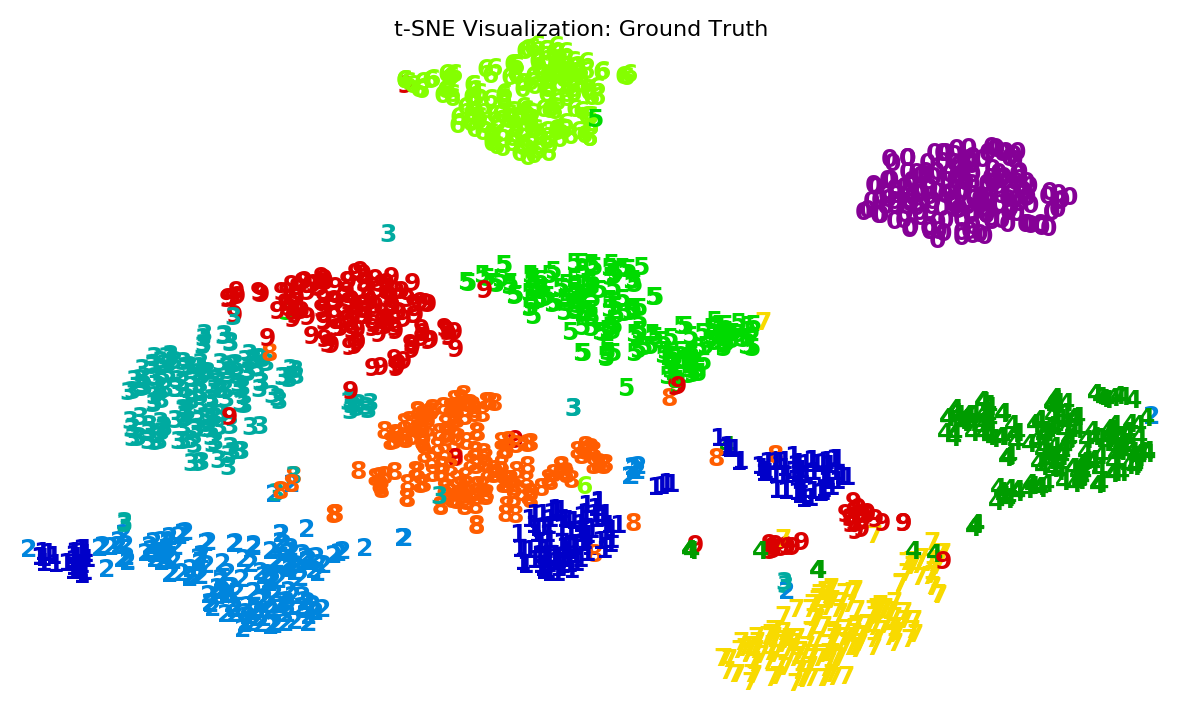

In [5]:
# Visualize the clusters
def plot_clustering(X_1, labels, title=None):
    
    x_min, x_max = np.min(X_1, axis=0), np.max(X_1, axis=0)
    X_ip = (X_1 - x_min) / (x_max - x_min)

    plt.rcParams['figure.dpi'] = 200
    #plt.figure(figsize=(6, 4))

    for i in range(X_ip.shape[0]):
        plt.text(X_ip[i, 0], X_ip[i, 1], str(digits_labels[i]), 
                 color=plt.cm.nipy_spectral((labels[i]+1)/(len(np.unique(labels))+1)), 
                 fontdict={'weight': 'bold', 'size': 9})
    plt.xticks([])
    plt.yticks([])
    if title is not None:
        plt.title(title, size=8)
    plt.axis('off')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

#Visualize the PCA dataset 
plot_clustering(pdigits_data, digits_labels, "PCA Visualization: Ground Truth")

#Visualize the t-SNE dataset
plot_clustering(tdigits_data, digits_labels, "t-SNE Visualization: Ground Truth")

### Section B: Data Pre-processing and Cluster Evaluation

In [0]:
#Calculate the evalution scores
def get_scores(X, label_true, label_pred):
    print("Homogeneity: %0.3f" % metrics.homogeneity_score(label_true, label_pred))
    print("Completeness: %0.3f" % metrics.completeness_score(label_true, label_pred))
    print("V-measure: %0.3f" % metrics.v_measure_score(label_true, label_pred))
    print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(label_true, label_pred))
    print("Adjusted Mutual Information: %0.3f" % metrics.adjusted_mutual_info_score(label_true, label_pred))
    s_coeff = metrics.silhouette_score(X, label_pred)
    print("Silhouette Coefficient: %0.3f" % s_coeff)
    return s_coeff

#### Algorithm A: K-Means

K-Means Clustering: K = 10
Time:	0.15s
Homogeneity: 0.643
Completeness: 0.651
V-measure: 0.647
Adjusted Rand Index: 0.487
Adjusted Mutual Information: 0.640
Silhouette Coefficient: 0.453


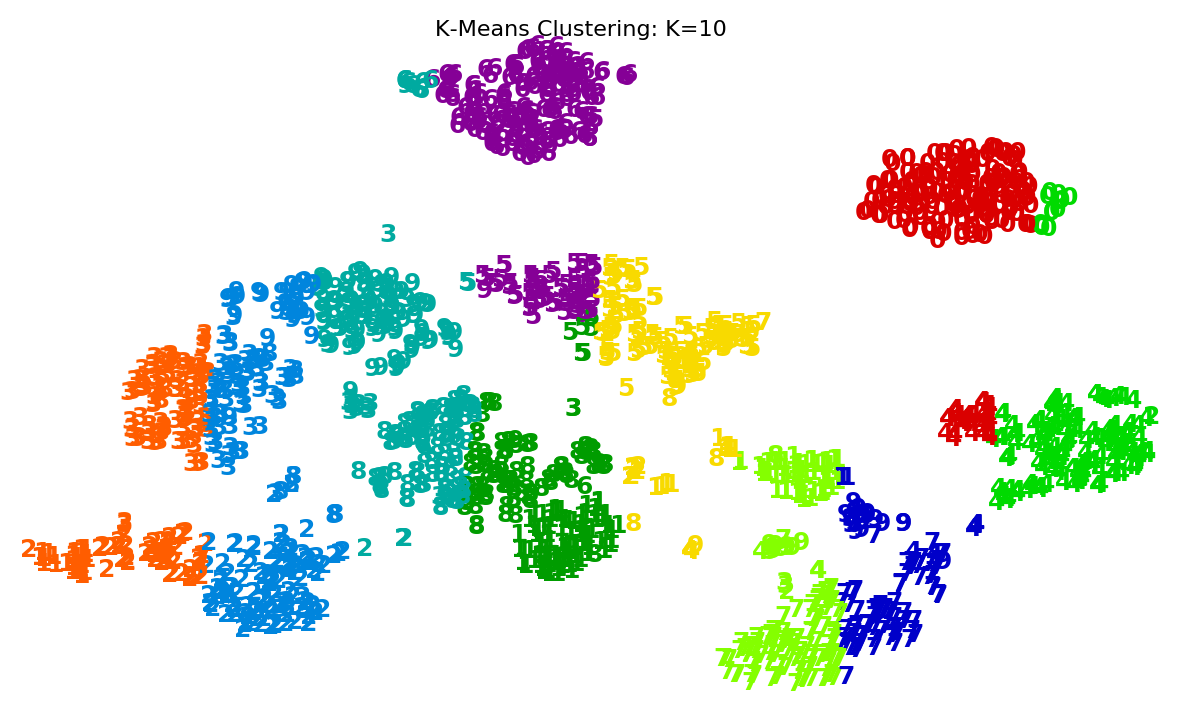

K-Means Clustering: K = 10
Time:	0.12s
Homogeneity: 0.854
Completeness: 0.863
V-measure: 0.859
Adjusted Rand Index: 0.807
Adjusted Mutual Information: 0.853
Silhouette Coefficient: 0.593


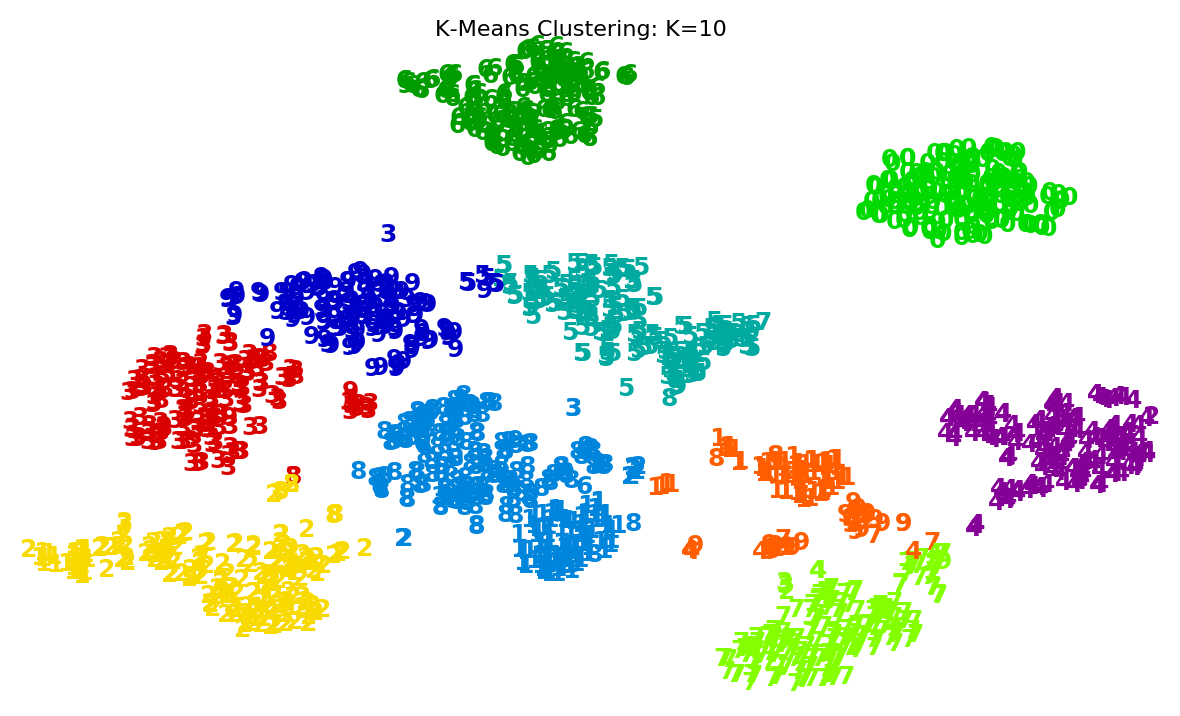

In [12]:
def kmeans_cl(X_input, Y_gtruth, k):
    t0 = time()
    k_means = KMeans(n_clusters=k, random_state=0).fit(X_input)
    print("K-Means Clustering: K = "+str(k)+"\nTime:\t%.2fs" % (time() - t0))

    s_coeff = get_scores(X_input, Y_gtruth, k_means.labels_)
    plot_clustering(X_input, k_means.labels_, "K-Means Clustering: K="+str(k))
    return k_means.labels_, s_coeff

#Distorted dataset
t_data = np.copy(tdigits_data)
t_data[:,0] = 5.0 * t_data[:,0]
#print(t_data[:2])

#Run the K-means algorithm
labels, s_coeff = kmeans_cl(t_data,digits_labels,n_digits)

#Scale the dataset
t_data = scale(t_data)

#Run the K-means algorithm
labels, s_coeff = kmeans_cl(t_data,digits_labels,n_digits)

### Section C: Overview of Clustering Methods

#### Algorithm B: DBSCAN

DBSCAN Clustering: EPS:  0.145 , Min Points:  10
Estimated number of clusters: 11
Estimated number of noise points: 24
Core Sample Indices:  1719 

Homogeneity: 0.860
Completeness: 0.848
V-measure: 0.854
Adjusted Rand Index: 0.802
Adjusted Mutual Information: 0.846
Silhouette Coefficient: 0.542


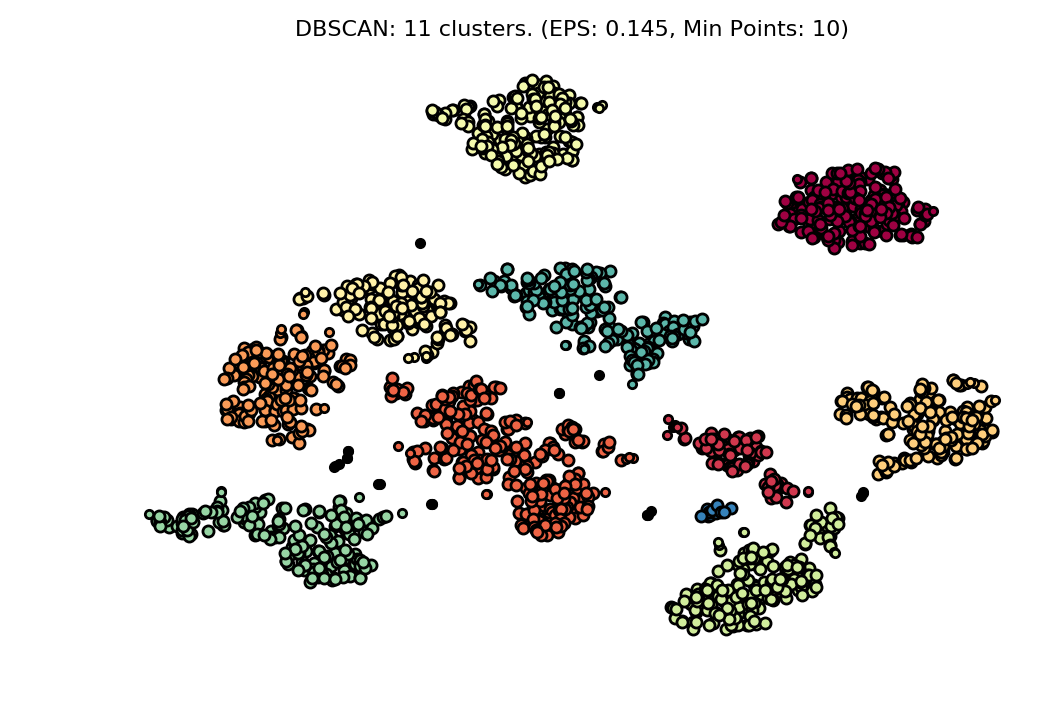

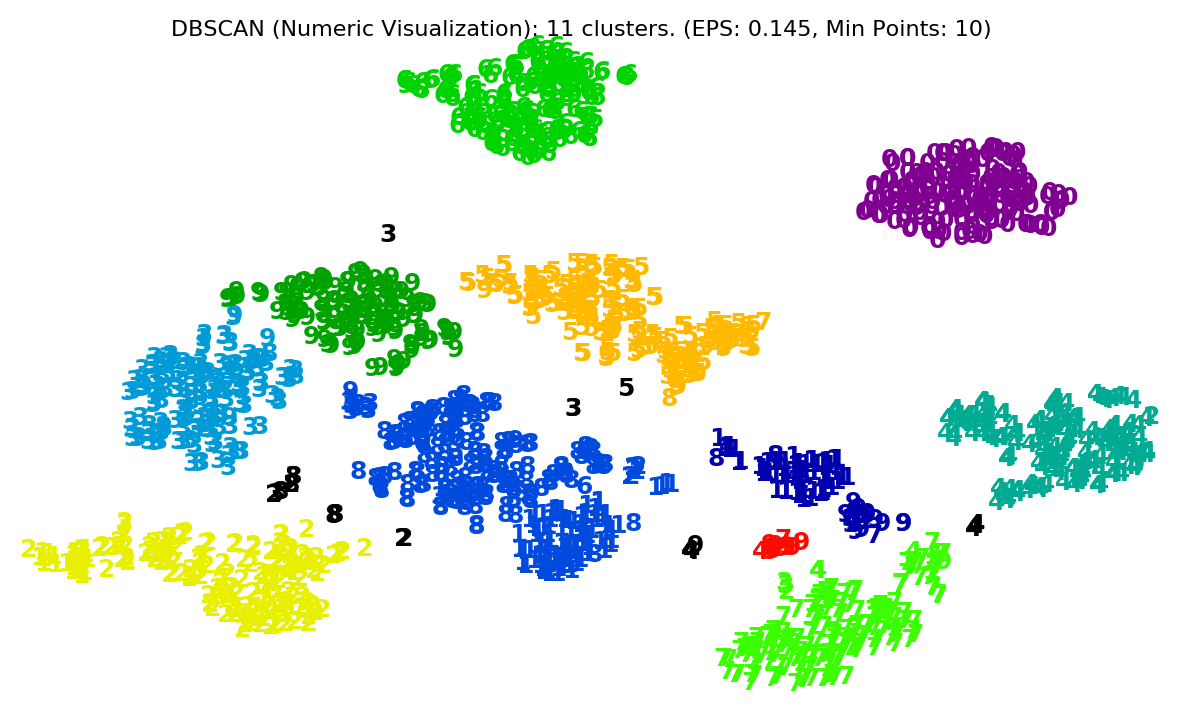

In [9]:
def dbscan_cl(X_input, Y_gtruth, eps, minsamples):
    
    print("DBSCAN Clustering: EPS: ",eps,", Min Points: ",minsamples)
    db = DBSCAN(eps=eps, min_samples=minsamples).fit(X_input)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True

    labels = db.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    print('Estimated number of clusters: %d' % n_clusters_)
    print('Estimated number of noise points: %d' % n_noise_)
    print('Core Sample Indices: ',len(db.core_sample_indices_),"\n")

    unique_labels = set(labels)
    
    #Evaluate the clusters
    if len(unique_labels) > 1:
        s_coeff = get_scores(X_input, Y_gtruth, labels)
    else:
        print("All points detected as noise!")
        s_coeff = 0.0

    # Plot result
    # Black removed and is used for noise instead.
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = (labels == k)

        xy = X_input[class_member_mask & core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=4)

        xy = X_input[class_member_mask & ~core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], '.', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=6)

    plt.title("DBSCAN: "+str(n_clusters_)+" clusters. (EPS: "+str(eps)+", Min Points: "+str(minsamples)+")", size=8)
    plt.axis('off')
    plt.show()

    #Alternate plot showing numbers
    plot_clustering(X_input, db.labels_, "DBSCAN (Numeric Visualization): "+str(n_clusters_)+" clusters. (EPS: "+
                    str(eps)+", Min Points: "+str(minsamples)+")")
    
    return db.labels_, s_coeff

    
#Call the DBSCAN algorithm
labels, s_coeff = dbscan_cl(tdigits_data, digits_labels, 0.145, 10)

#### Algorithm C. Agglomerative

Agglomerative Clustering:
Input Matrix:  (1797, 2) 

Linkage: ward 
Time:	0.09s
Homogeneity: 0.840
Completeness: 0.848
V-measure: 0.844
Adjusted Rand Index: 0.780
Adjusted Mutual Information: 0.838
Silhouette Coefficient: 0.589


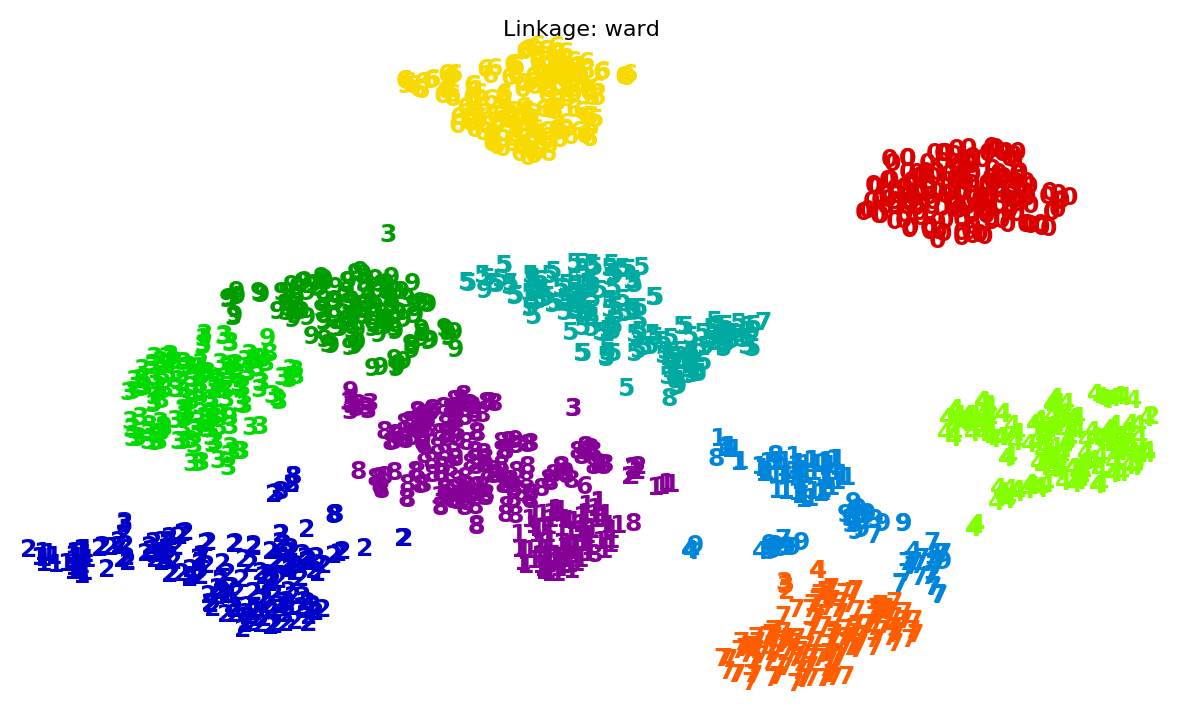

Agglomerative Clustering:
Input Matrix:  (1797, 2) 

Linkage: average 
Time:	0.09s
Homogeneity: 0.840
Completeness: 0.850
V-measure: 0.845
Adjusted Rand Index: 0.777
Adjusted Mutual Information: 0.839
Silhouette Coefficient: 0.588


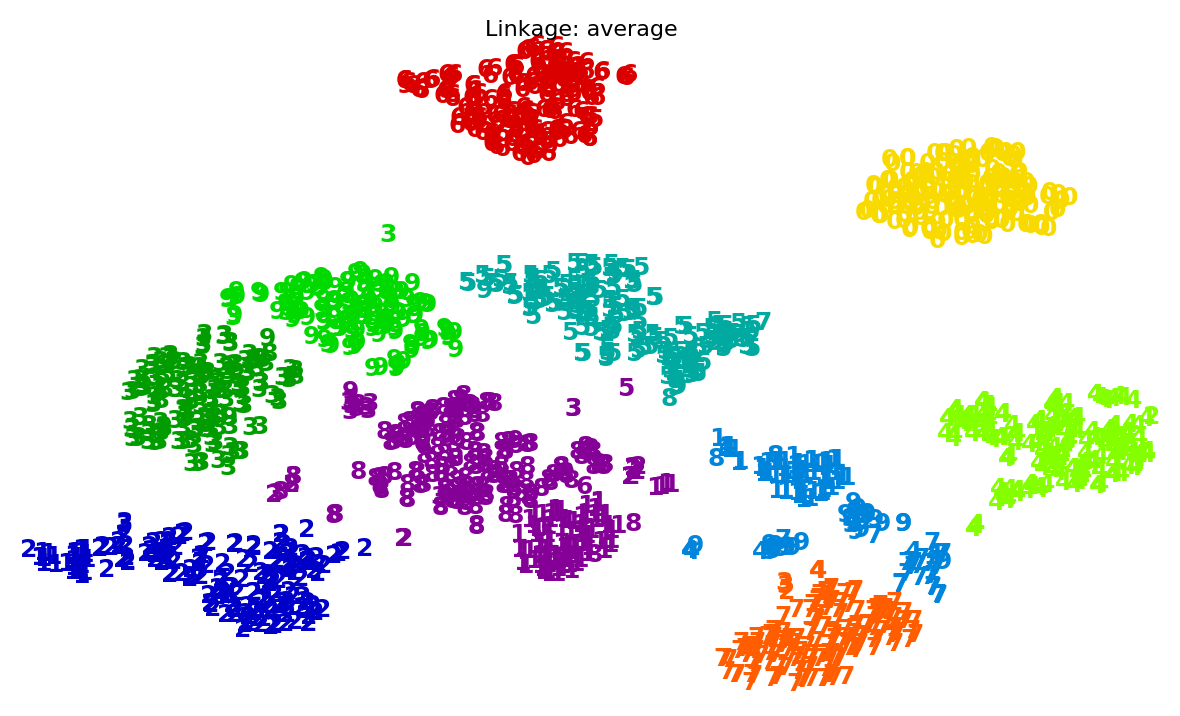

Agglomerative Clustering:
Input Matrix:  (1797, 2) 

Linkage: complete 
Time:	0.08s
Homogeneity: 0.812
Completeness: 0.819
V-measure: 0.815
Adjusted Rand Index: 0.740
Adjusted Mutual Information: 0.810
Silhouette Coefficient: 0.562


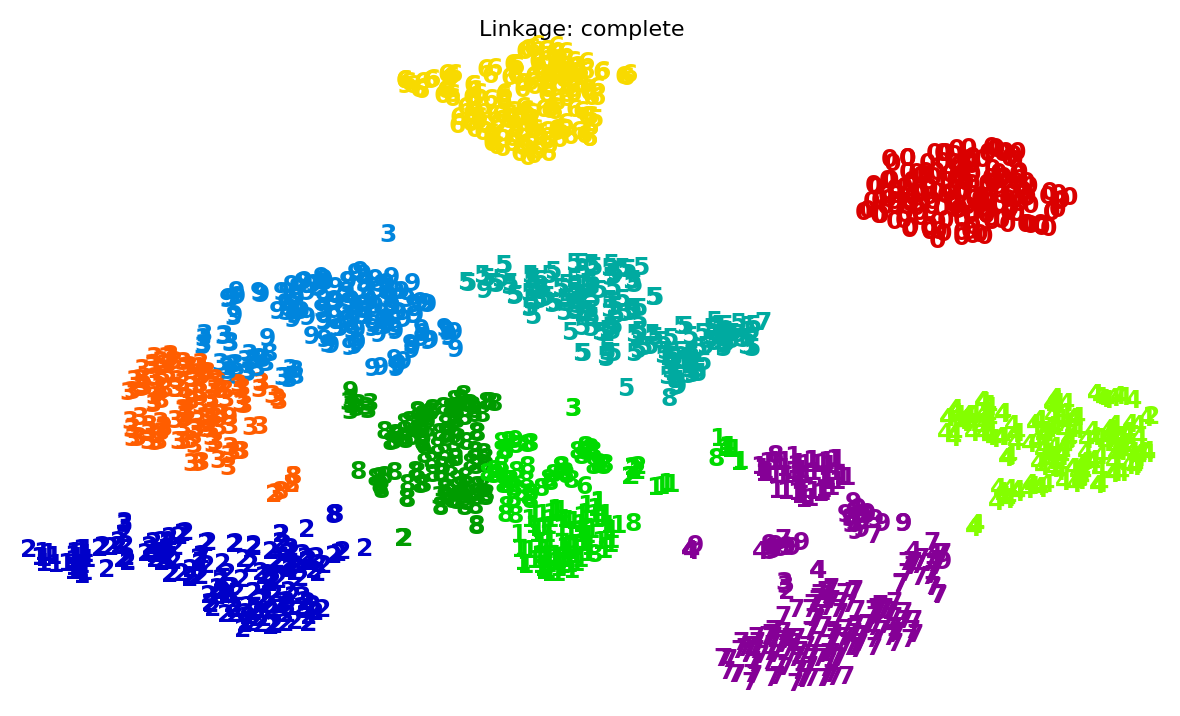

Agglomerative Clustering:
Input Matrix:  (1797, 2) 

Linkage: single 
Time:	0.05s
Homogeneity: 0.623
Completeness: 0.845
V-measure: 0.717
Adjusted Rand Index: 0.484
Adjusted Mutual Information: 0.620
Silhouette Coefficient: 0.105


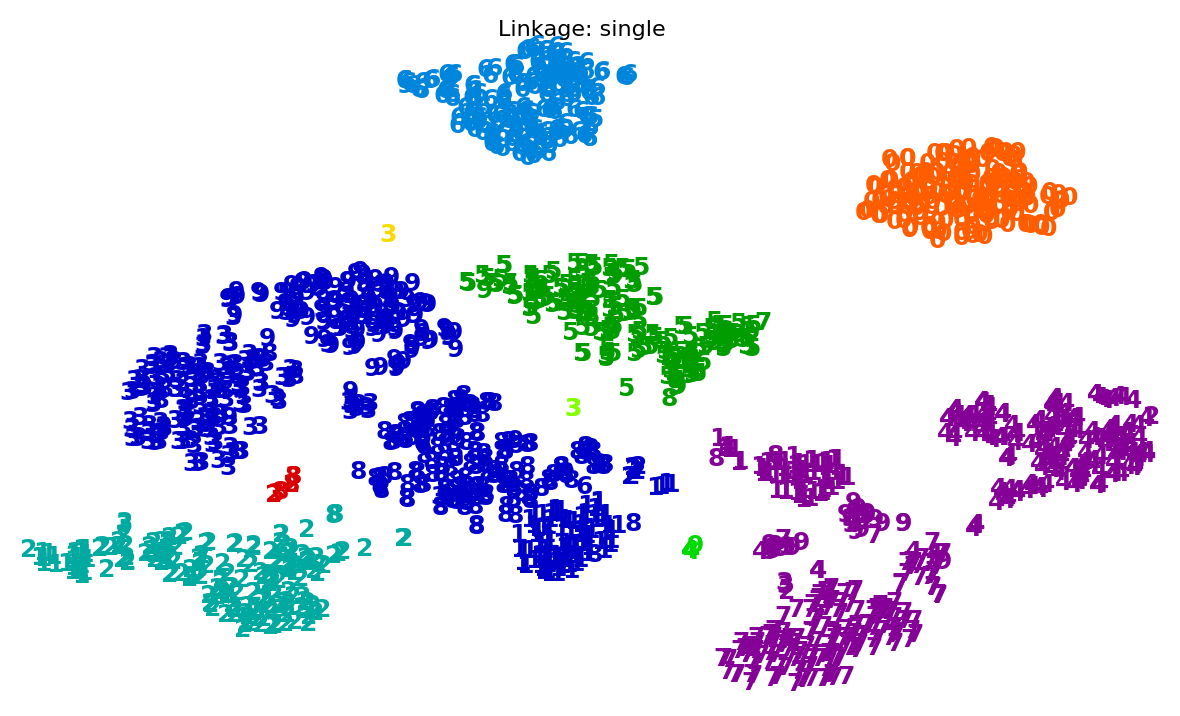

In [10]:
def agglo_cl(X_input, Y_gtruth, linkage):

    print("Agglomerative Clustering:\nInput Matrix: ",np.shape(X_input),"\n")

    agglo = AgglomerativeClustering(linkage=linkage, n_clusters=10)
    t0 = time()
    agglo.fit(X_input)
    print("Linkage: %s \nTime:\t%.2fs" % (linkage, time() - t0))

    #Evaluate the clusters
    s_coeff = get_scores(X_input, Y_gtruth, agglo.labels_)

    plot_clustering(X_input, agglo.labels_, "Linkage: %s" % linkage)

    return agglo.labels_, s_coeff

#Call the Agglomerative clustering algorithm
for linkage in ('ward', 'average', 'complete', 'single'):
    try:
        labels, s_coeff = agglo_cl(tdigits_data, digits_labels, linkage)
    except:
        print("Error: ",linkage)

#### Algorithm D: Spectral

Spectral Clustering:
Input Matrix:  (1797, 2) 

Time Consumed: 	0.45s
Homogeneity: 0.845
Completeness: 0.863
V-measure: 0.854
Adjusted Rand Index: 0.788
Adjusted Mutual Information: 0.844
Silhouette Coefficient: 0.575


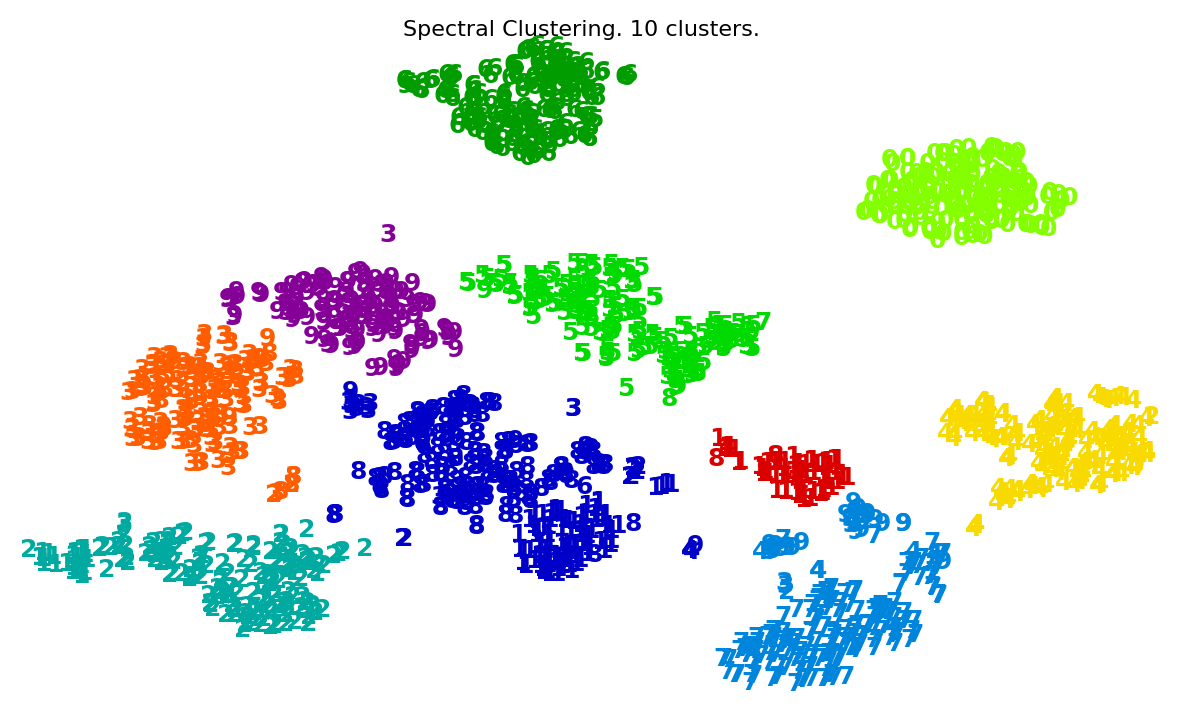

In [16]:
def spec_cl(X_input, Y_gtruth, n, n_neigh):
    
    print("Spectral Clustering:\nInput Matrix: ",np.shape(X_input),"\n")
    spectral = SpectralClustering(n_clusters=n, eigen_solver='arpack', affinity="nearest_neighbors", n_neighbors=n_neigh)
    t0 = time()
    spectral.fit(scale(X_input))
    print("Time Consumed: \t%.2fs" % (time() - t0))

    #Evaluate the clusters
    s_coeff = get_scores(X_input, Y_gtruth, spectral.labels_)
    
    plot_clustering(X_input, spectral.labels_, "Spectral Clustering. "+str(n)+" clusters.")
    return spectral.labels_, s_coeff
    
labels, s_coeff = spec_cl(tdigits_data, digits_labels, n_digits, 15)

### Section D: Find Optimal Clustering Parameters

In [0]:
#Function to plot relation between 'x' and 'y' quantities
def plot_line(x_vals, y_vals, title):
    
    plt.figure()
    plt.xticks(x_vals)
    plt.plot(x_vals, y_vals, marker = 'o')
    plt.gca().yaxis.grid(True)
    plt.title(title,size='8')        
    plt.show()

#### K-Means: Silhoutte coeffcient v/s 'k'

K-Means Clustering: K = 2
Time:	0.05s
Homogeneity: 0.267
Completeness: 0.912
V-measure: 0.413
Adjusted Rand Index: 0.176
Adjusted Mutual Information: 0.266
Silhouette Coefficient: 0.368


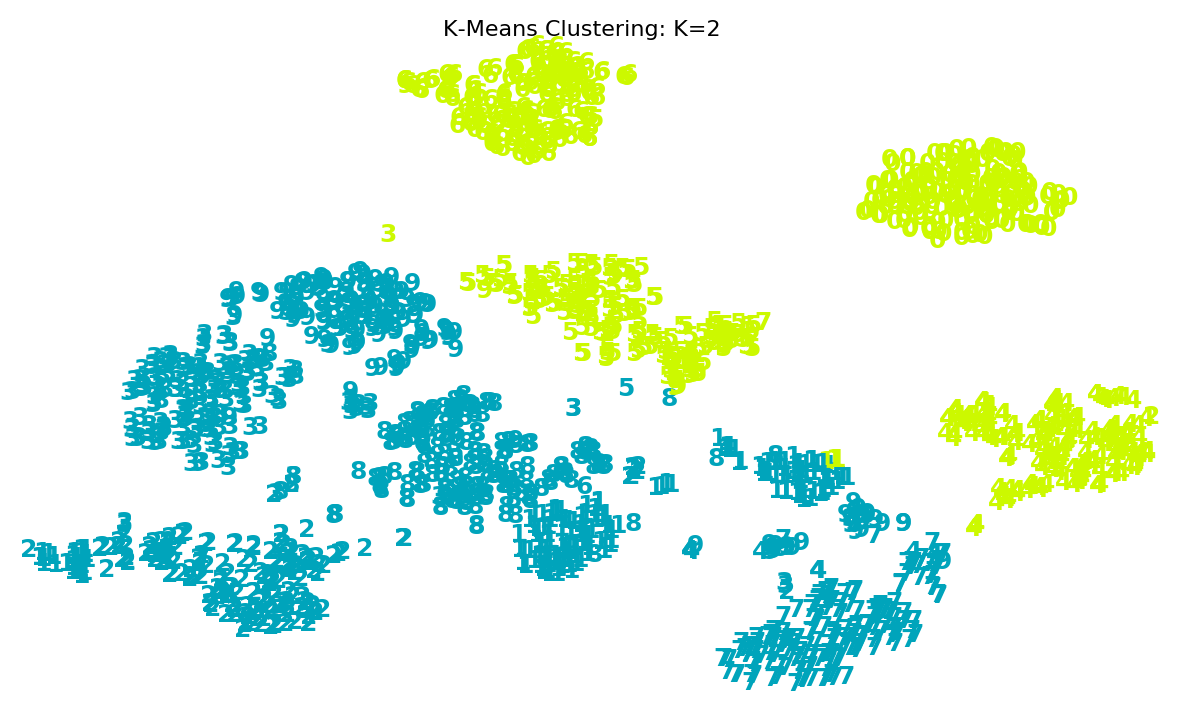

K-Means Clustering: K = 3
Time:	0.07s
Homogeneity: 0.390
Completeness: 0.835
V-measure: 0.532
Adjusted Rand Index: 0.289
Adjusted Mutual Information: 0.389
Silhouette Coefficient: 0.461


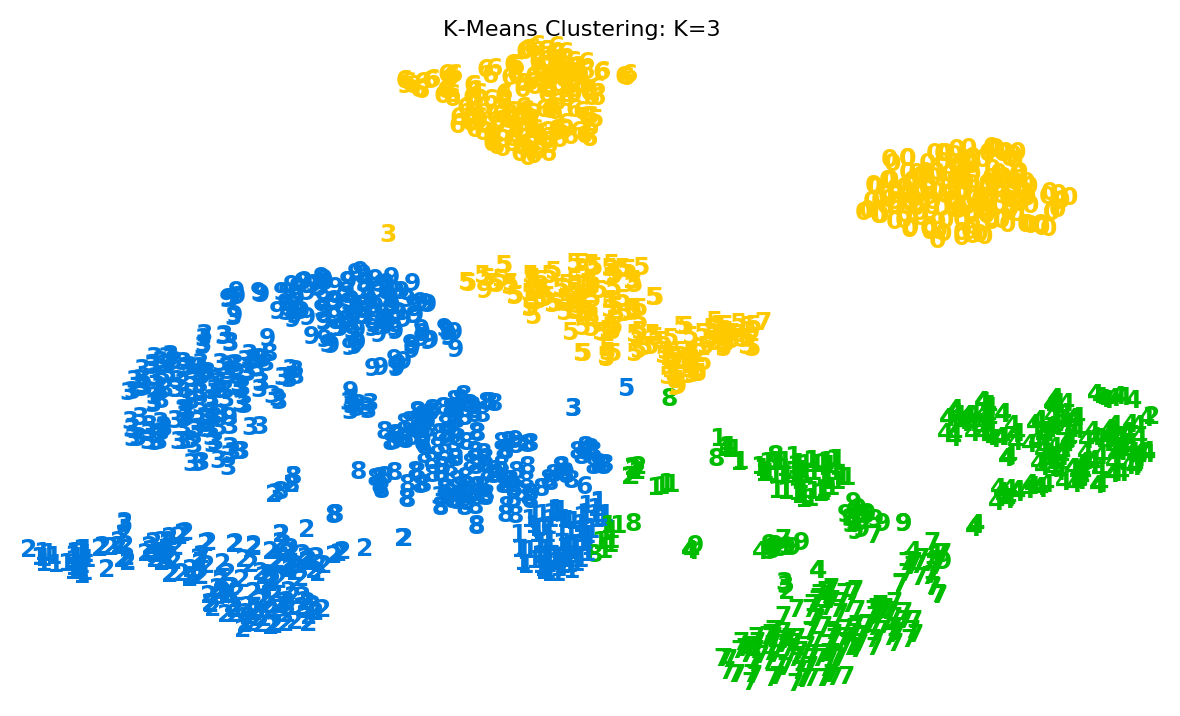

K-Means Clustering: K = 4
Time:	0.10s
Homogeneity: 0.484
Completeness: 0.855
V-measure: 0.618
Adjusted Rand Index: 0.366
Adjusted Mutual Information: 0.482
Silhouette Coefficient: 0.454


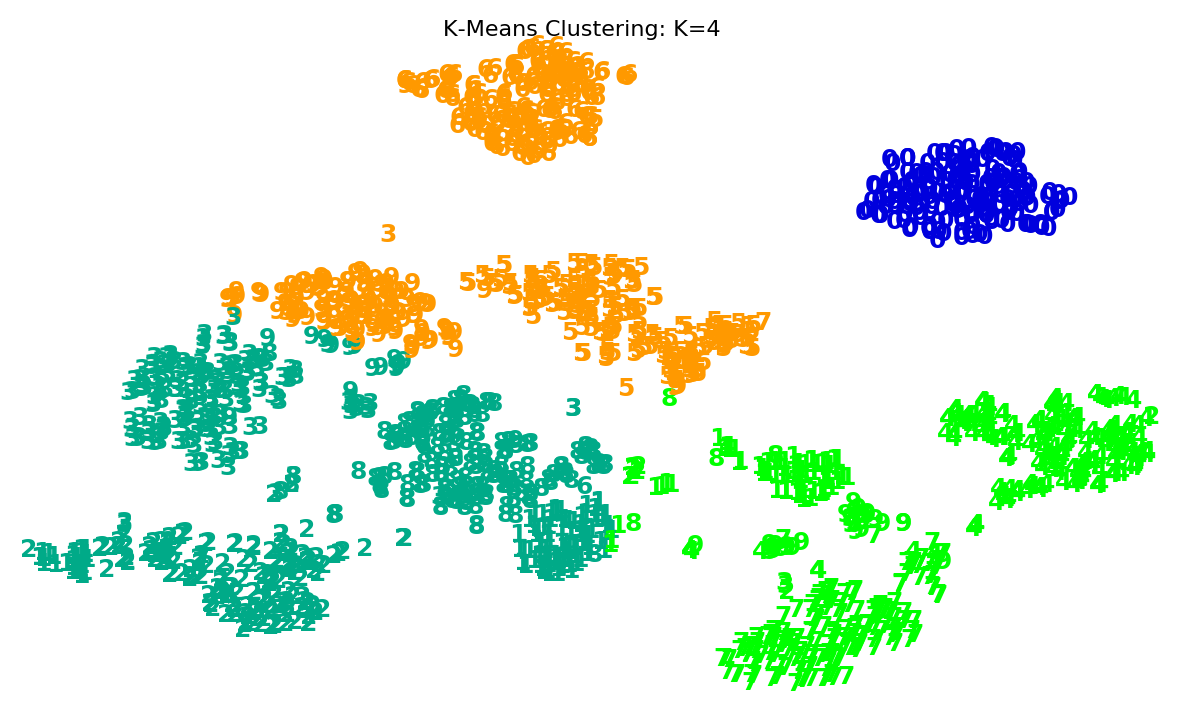

K-Means Clustering: K = 5
Time:	0.12s
Homogeneity: 0.537
Completeness: 0.816
V-measure: 0.648
Adjusted Rand Index: 0.412
Adjusted Mutual Information: 0.535
Silhouette Coefficient: 0.470


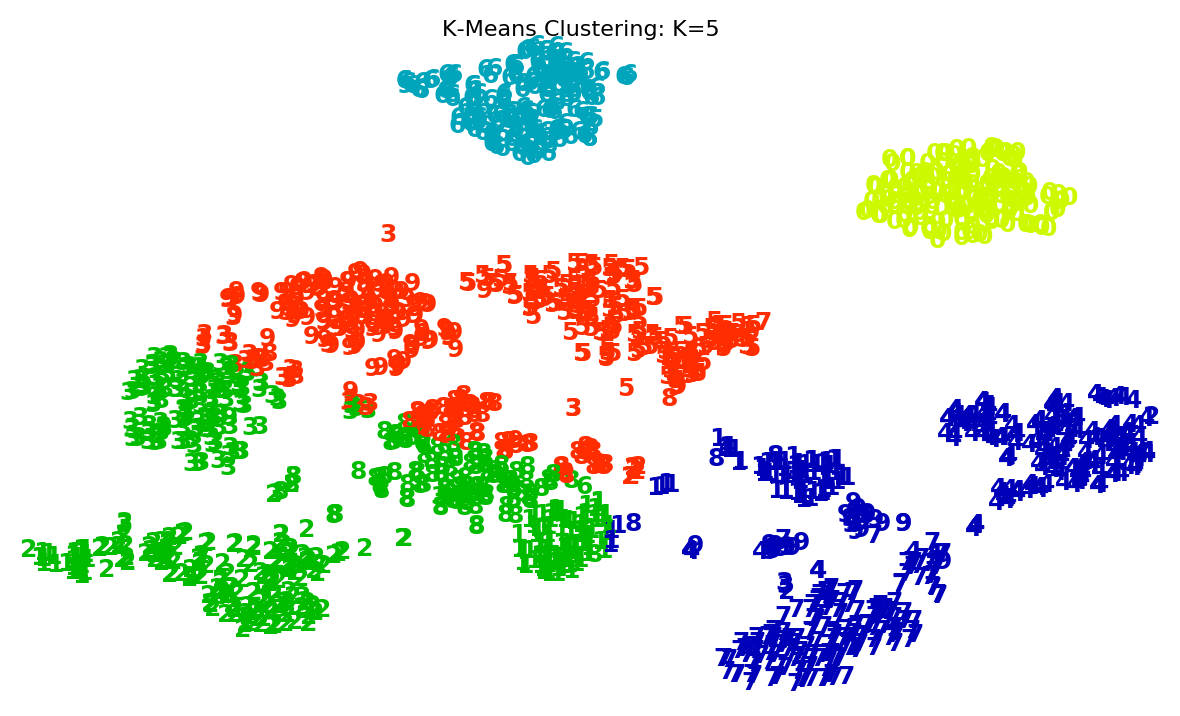

K-Means Clustering: K = 6
Time:	0.11s
Homogeneity: 0.618
Completeness: 0.835
V-measure: 0.710
Adjusted Rand Index: 0.503
Adjusted Mutual Information: 0.615
Silhouette Coefficient: 0.493


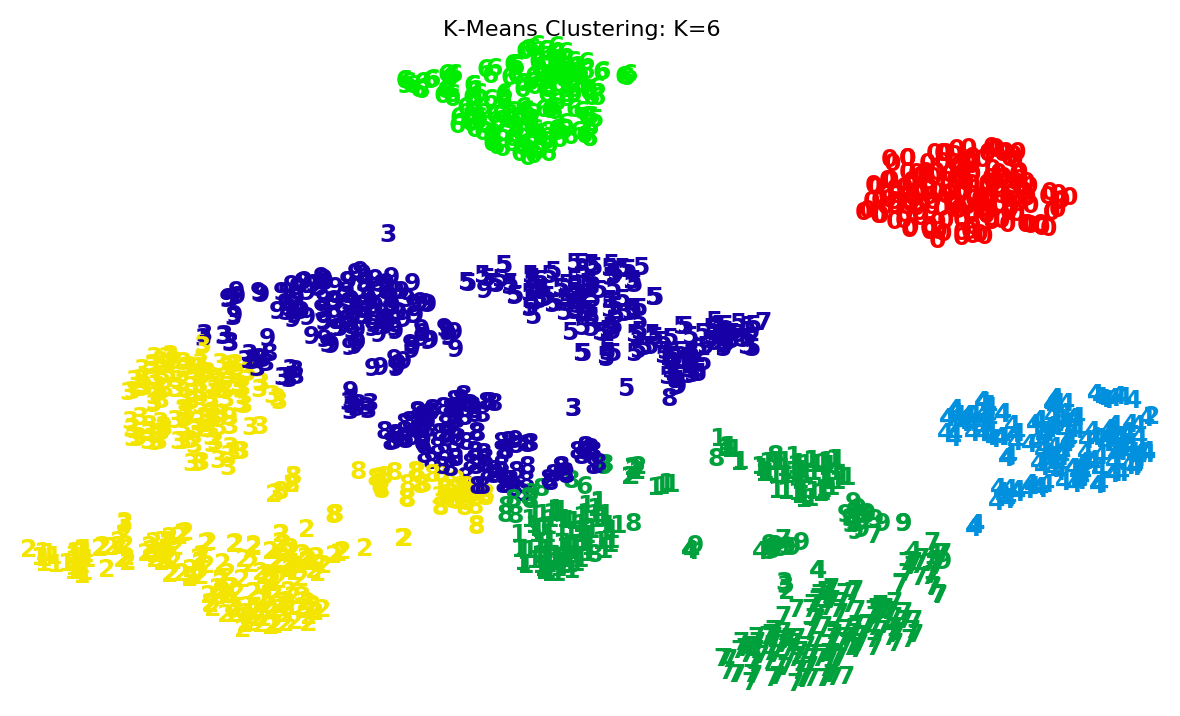

K-Means Clustering: K = 7
Time:	0.11s
Homogeneity: 0.698
Completeness: 0.847
V-measure: 0.765
Adjusted Rand Index: 0.619
Adjusted Mutual Information: 0.696
Silhouette Coefficient: 0.520


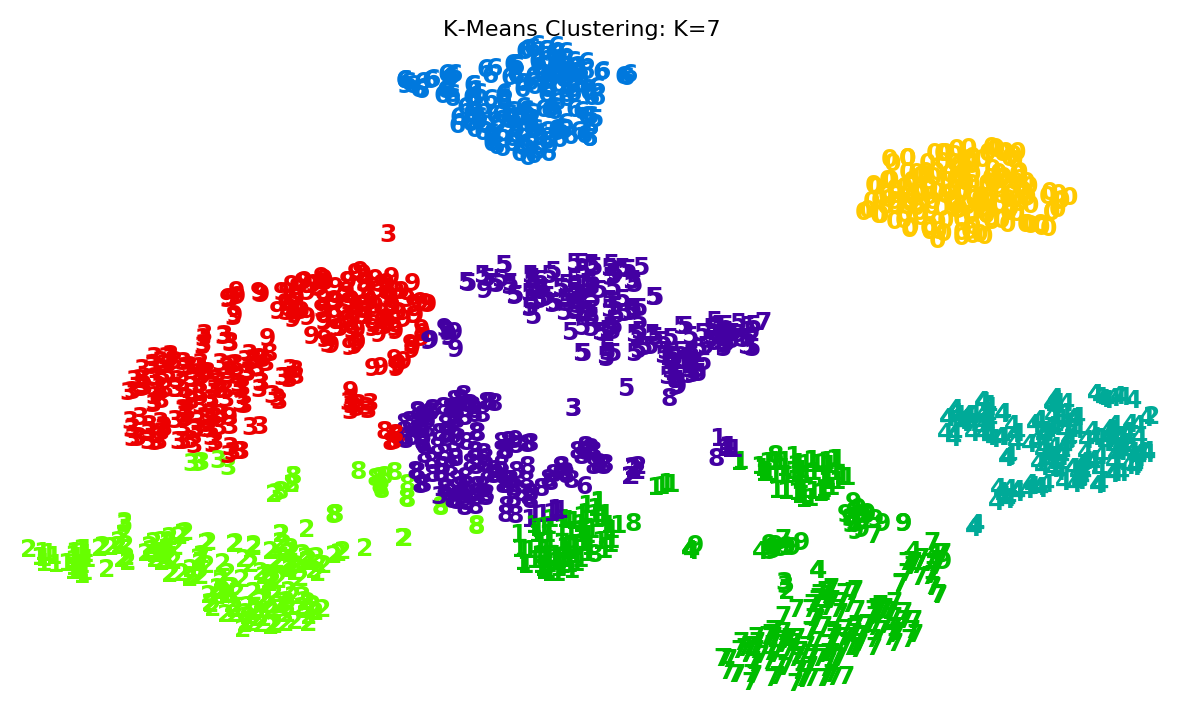

K-Means Clustering: K = 8
Time:	0.09s
Homogeneity: 0.763
Completeness: 0.855
V-measure: 0.806
Adjusted Rand Index: 0.701
Adjusted Mutual Information: 0.761
Silhouette Coefficient: 0.583


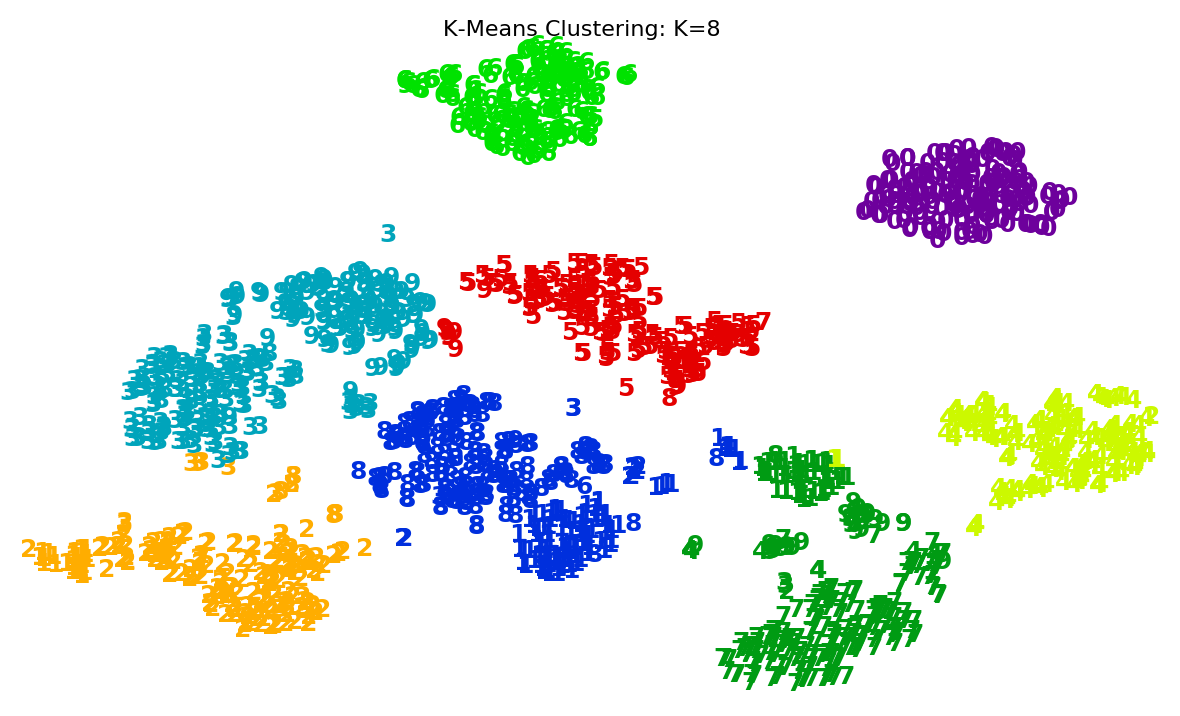

K-Means Clustering: K = 9
Time:	0.11s
Homogeneity: 0.803
Completeness: 0.856
V-measure: 0.829
Adjusted Rand Index: 0.741
Adjusted Mutual Information: 0.801
Silhouette Coefficient: 0.587


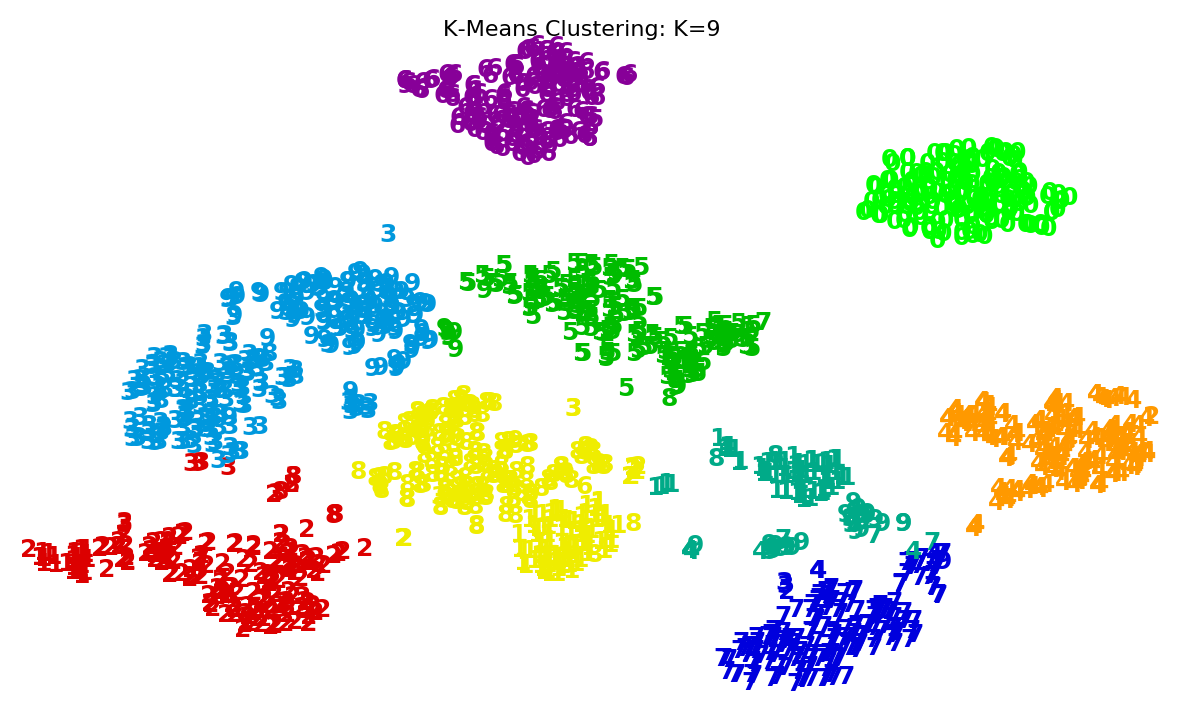

K-Means Clustering: K = 10
Time:	0.12s
Homogeneity: 0.854
Completeness: 0.863
V-measure: 0.859
Adjusted Rand Index: 0.807
Adjusted Mutual Information: 0.853
Silhouette Coefficient: 0.593


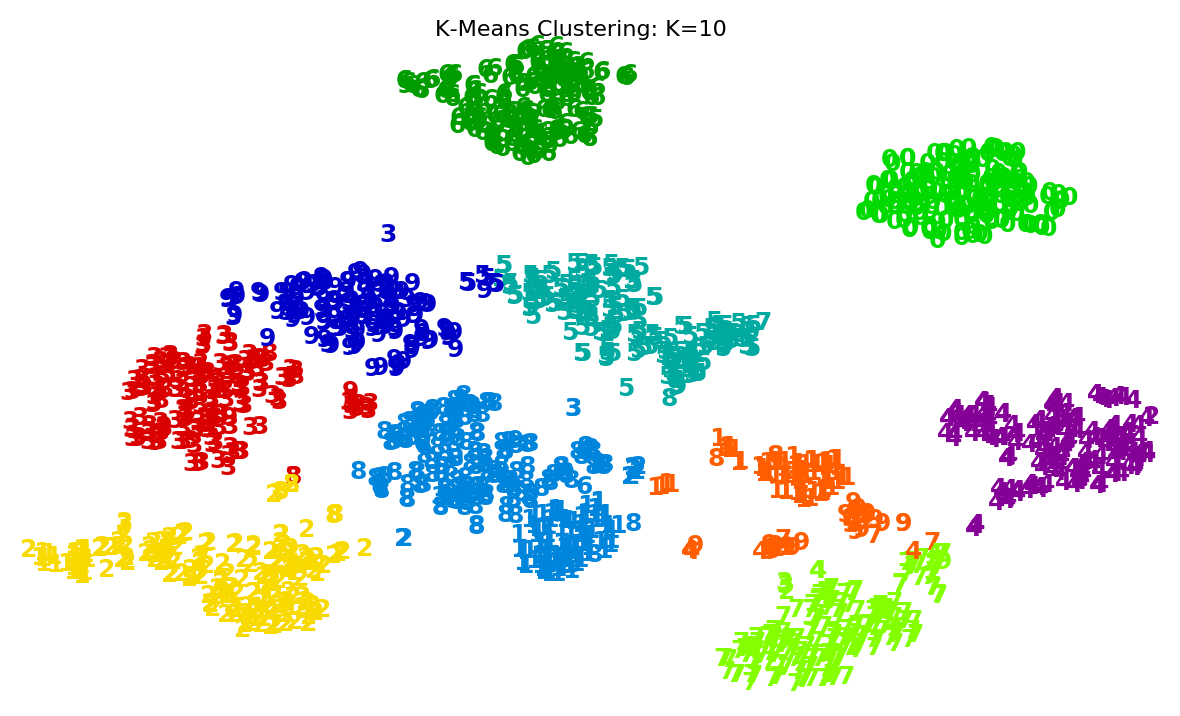

In [19]:
#Run the K-Means algorithm for k=2 to 10
k_vals, s_coeff_vals = [], []

for k in range(2,11):
    k_vals.append(k)
    labels, coeff = kmeans_cl(tdigits_data,digits_labels,k)
    s_coeff_vals.append(coeff)

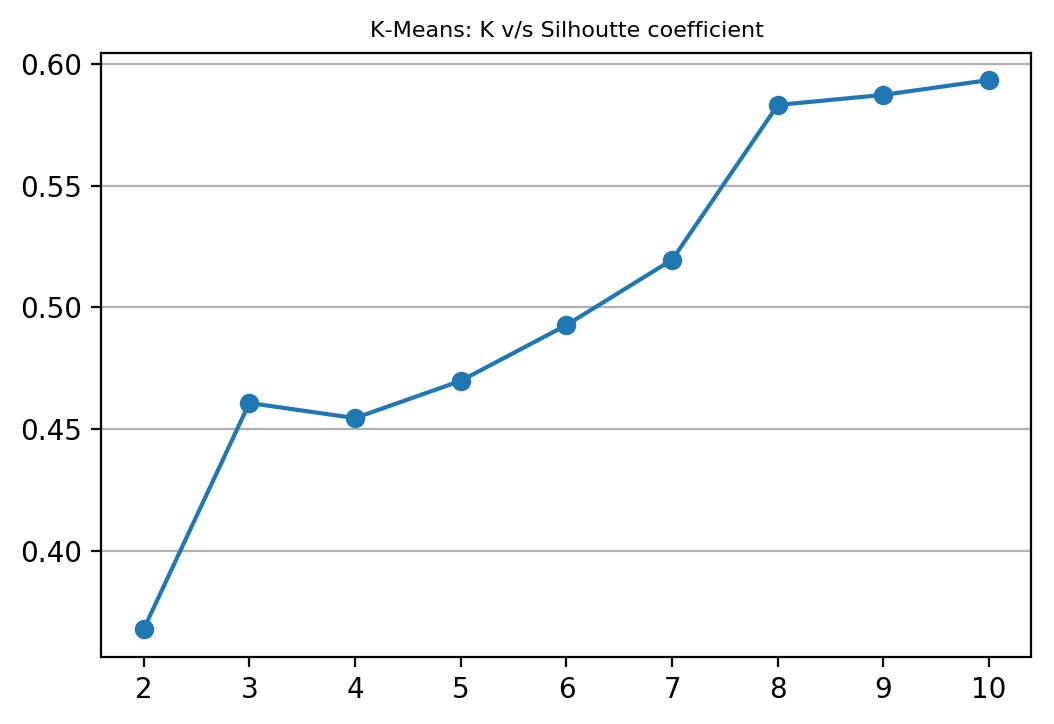

In [20]:
plot_line(k_vals,s_coeff_vals,'K-Means: K v/s Silhoutte coefficient')

#### DBSCAN: Silhoutte coeffcient v/s 'eps'

In [21]:
#Run the DBSCAN algorithm for eps=0.10 to 0.4
eps_vals, s_coeff_vals = [], []
eps, minsam = 0.08, 5
while eps <= 0.26:
    eps_vals.append(eps)
    labels, coeff = dbscan_cl(tdigits_data, digits_labels, eps, minsam)
    s_coeff_vals.append(coeff)
    eps = round(eps+0.02,2)

Output hidden; open in https://colab.research.google.com to view.

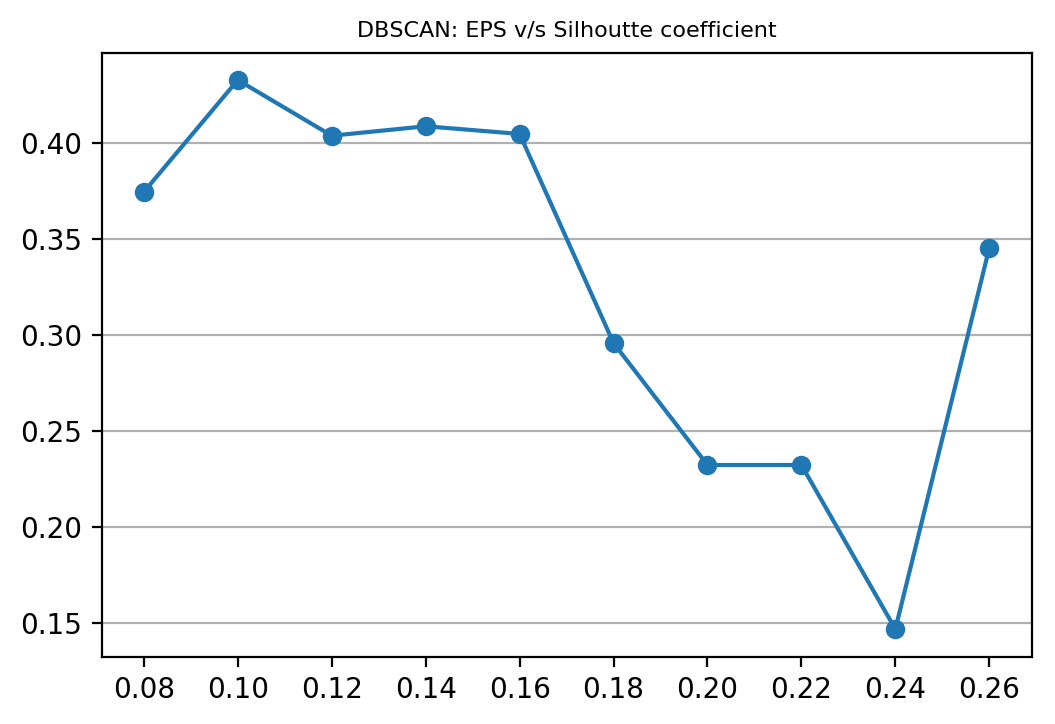

In [22]:
plot_line(eps_vals,s_coeff_vals,'DBSCAN: EPS v/s Silhoutte coefficient')

#### DBSCAN: Silhoutte coeffcient v/s 'Minimum Samples'

In [23]:
minsam_vals, s_coeff_vals = [], []
eps, minsam = 0.13, 1
while minsam <= 10:
    minsam_vals.append(minsam)
    labels, coeff = dbscan_cl(tdigits_data, digits_labels, eps, minsam)
    s_coeff_vals.append(coeff)
    minsam += 1

Output hidden; open in https://colab.research.google.com to view.

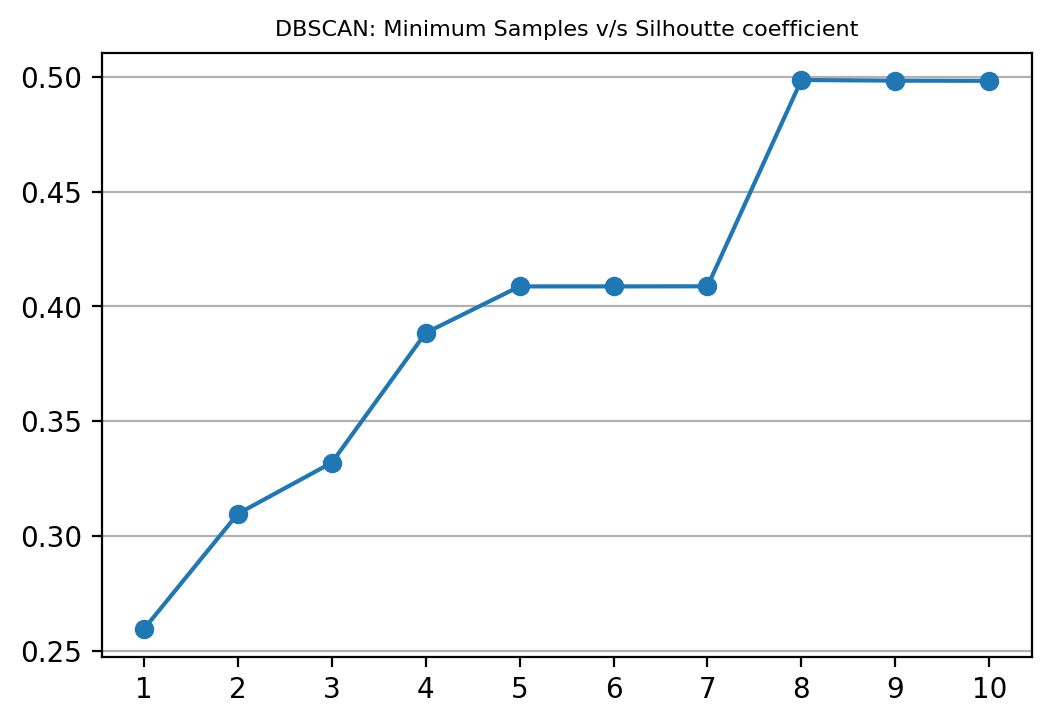

In [24]:
plot_line(minsam_vals,s_coeff_vals,'DBSCAN: Minimum Samples v/s Silhoutte coefficient')

### Section E: Application of Clustering

In [0]:
#Calculate the ward distance between the two clusters pairs
def ward_distance(a1,a2):
    ma, mb = a1.sum(axis=0)/len(a1), a2.sum(axis=0)/len(a2)
    ssum = (ma - mb)
    #print("Centroid 1: ",ma,", Centroid 2: ", mb,", Diff: ",np.round(ssum,1))
    ssum *= ssum
    ssum = ssum.sum(axis=0)
    ssum = (ssum*len(a1)*len(a2))/(len(a1)+len(a2))
    return ssum 

#Plot the clusters with their centroids
def plt_cen(mat,title):

    fig = plt.figure()
    for i in np.unique(mat[:,2]):
        
        cn = mat[np.where(mat[:,2]==i)]
        plt.plot(cn[:,0], cn[:,1], 'o', markeredgecolor='k', markersize=4)
        
        center = cn[:,:2].sum(axis=0)/len(cn)
        #print(cn[0,2]," ======> ",center)
        plt.text(center[0],center[1], str(i), color='black', 
                 fontdict={'weight': 'bold', 'size': 6},bbox=dict(boxstyle="round", ec="0.0",fc="w"))

    plt.title(title,size='8')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.axis('off')
    plt.show()

#### Nearest Digit Pairs from Ground Truth (t-SNE data)

Similar Pairs: 
 [[  1.     8.    22.24]
 [  5.     9.    38.66]
 [  8.     9.    41.01]
 [  3.     9.    62.06]
 [  3.     8.    79.21]
 [  2.     8.    87.62]
 [  5.     8.    94.3 ]
 [  2.     3.   100.41]
 [  1.     2.   113.21]
 [  1.     9.   114.91]]


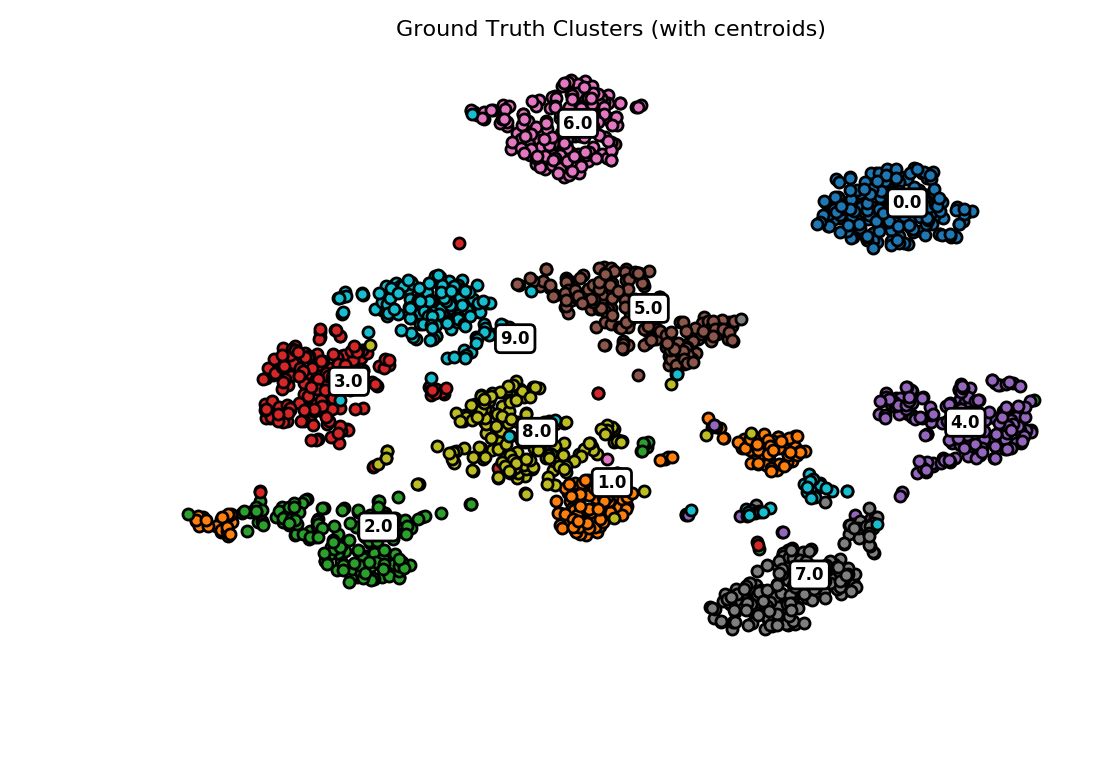

In [27]:
data_new = np.concatenate((tdigits_data, digits_labels[:, None]), axis=1)
data_new = data_new[data_new[:, 2].argsort()]

#Calculate the number of digit cluster pairs possible
comb, counter = int(n_digits*(n_digits-1)/2), 0
dist_matrix = np.zeros((comb, 3))

for i in  range(0, n_digits-1):
    for j in range(i+1, n_digits):
        c1 = data_new[np.where(data_new[:,2]==i)]
        c2 = data_new[np.where(data_new[:,2]==j)]
        
        delta = np.round(ward_distance(c1[:,:2],c2[:,:2]),2)

        dist_matrix[counter,:] = np.array([i,j,delta])
        counter+=1
        #print("Digit:",i,", digit:",j,", Ward Distance:",delta)

dist_matrix = dist_matrix[dist_matrix[:, 2].argsort()]

#Top-5 most similar digit pairs
print("Similar Pairs: \n",dist_matrix[:10,:])

#Plot the clusters
plt_cen(data_new,"Ground Truth Clusters (with centroids)")

#### Nearest Digit Pairs from Clustering algorithms

In [0]:
#Calculate the nearest digit pairs from clustering algorithms
def getnearestclusters(X,labels_g_truth,labels_cluster):

    data_new = np.concatenate((scale(X), labels_g_truth[:, None]), axis=1)
    data_new = np.concatenate((data_new, labels_cluster[:, None]), axis=1)

    data_new = data_new[data_new[:, 3].argsort()]

    #Calculate which digit the cluster belongs to 
    print("\nCluster Digit Mapping:")
    clu_digit_map, rev_map = {}, {}
    for i in range(0, n_digits):

        n = data_new[np.where(data_new[:,2]==i)]

        unique, counts = np.unique(n[:,3], return_counts=True)
        tag_dist_dict = dict(zip(unique, counts))
        sorted(tag_dist_dict.items(), key=lambda x: x[1])
        clu_digit_map[i] = max(tag_dist_dict, key=tag_dist_dict.get)
        rev_map[clu_digit_map[i]] = i 
        print("Digit No.: ",i,", Cluster: ",clu_digit_map[i],", Number Distribution: ",tag_dist_dict)
        
    #For every cluster pair calculate the ward distance    
    comb, counter = int(n_digits*(n_digits-1)/2), 0
    dist_matrix = np.zeros((comb, 3))
    #print(rev_map)
    
    for i in  range(0, n_digits-1):
        for j in range(i+1, n_digits):
            c1 = data_new[np.where(data_new[:,3]==clu_digit_map[i])]
            c2 = data_new[np.where(data_new[:,3]==clu_digit_map[j])]

            delta = np.round(ward_distance(c1[:,:2],c2[:,:2]),2)

            dist_matrix[counter,:] = np.array([i,j,delta])
            counter+=1
            #print("Digit:",i,", digit:",j,", Ward Distance:",delta)
            
    dist_matrix = dist_matrix[dist_matrix[:, 2].argsort()]
    
    print("\nMost Similar Digit Pairs: \n",dist_matrix[:10,:])
    
    #Plot the clusters detected by the algorithm
    plt_cen(data_new[:,[0,1,3]],"Cluster Centroids (Detected by Algo)")
    
    #Plot the ground truth clusters
    plot_clustering(tdigits_data, digits_labels, "Clusters (Ground Truth)")

#### Nearest Digit Pairs (K-Means)

K-Means Clustering: K = 10
Time:	0.10s
Homogeneity: 0.854
Completeness: 0.863
V-measure: 0.859
Adjusted Rand Index: 0.807
Adjusted Mutual Information: 0.853
Silhouette Coefficient: 0.593


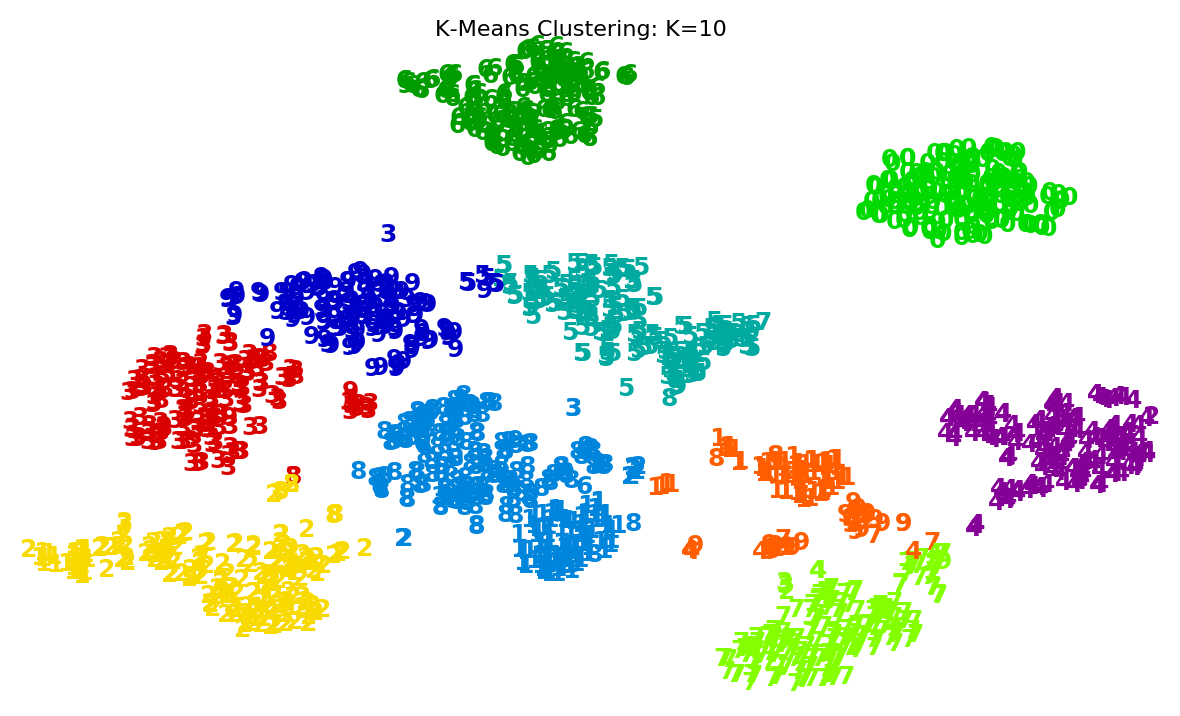


Cluster Digit Mapping:
Digit No.:  0 , Cluster:  5.0 , Number Distribution:  {5.0: 178}
Digit No.:  1 , Cluster:  2.0 , Number Distribution:  {2.0: 89, 7.0: 27, 8.0: 66}
Digit No.:  2 , Cluster:  7.0 , Number Distribution:  {0.0: 1, 2.0: 9, 6.0: 1, 7.0: 166}
Digit No.:  3 , Cluster:  9.0 , Number Distribution:  {1.0: 2, 2.0: 3, 6.0: 2, 7.0: 3, 9.0: 173}
Digit No.:  4 , Cluster:  0.0 , Number Distribution:  {0.0: 172, 6.0: 3, 8.0: 6}
Digit No.:  5 , Cluster:  3.0 , Number Distribution:  {1.0: 7, 3.0: 174, 4.0: 1}
Digit No.:  6 , Cluster:  4.0 , Number Distribution:  {2.0: 1, 4.0: 180}
Digit No.:  7 , Cluster:  6.0 , Number Distribution:  {3.0: 1, 6.0: 175, 8.0: 3}
Digit No.:  8 , Cluster:  2.0 , Number Distribution:  {2.0: 164, 3.0: 1, 7.0: 5, 8.0: 2, 9.0: 2}
Digit No.:  9 , Cluster:  1.0 , Number Distribution:  {1.0: 142, 2.0: 2, 3.0: 2, 4.0: 1, 6.0: 1, 8.0: 30, 9.0: 2}

Most Similar Digit Pairs: 
 [[  1.     8.     0.  ]
 [  3.     9.    45.79]
 [  5.     9.    71.56]
 [  2.     3.  

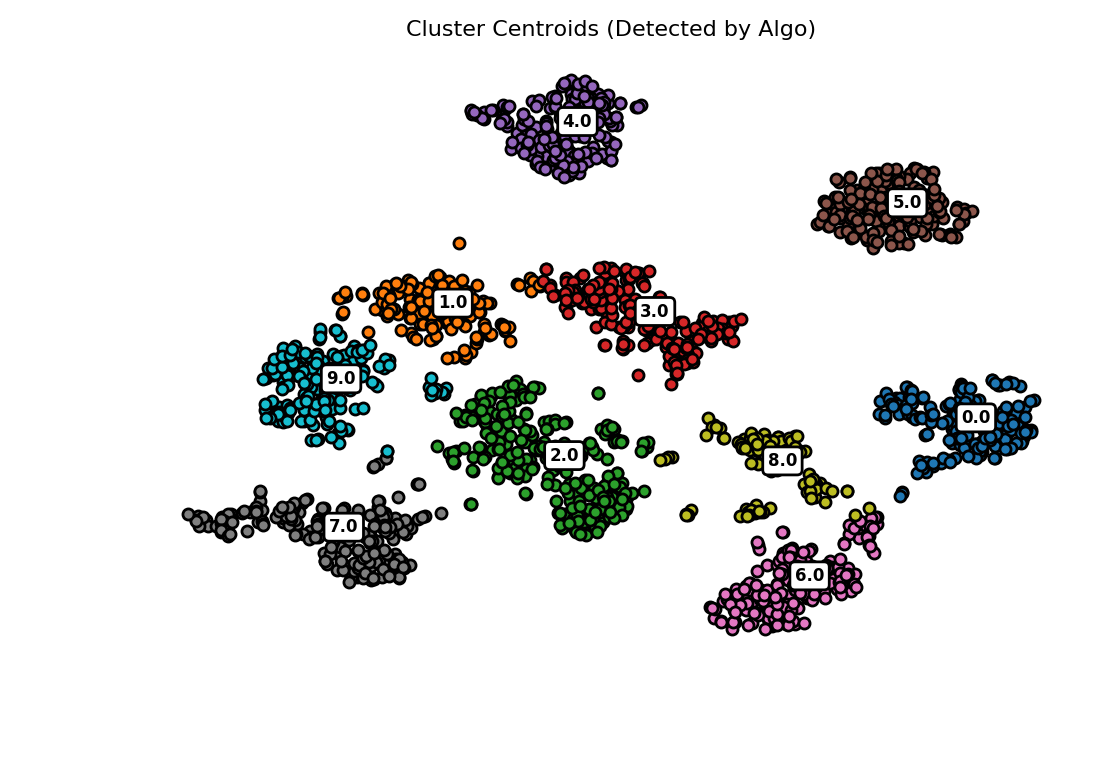

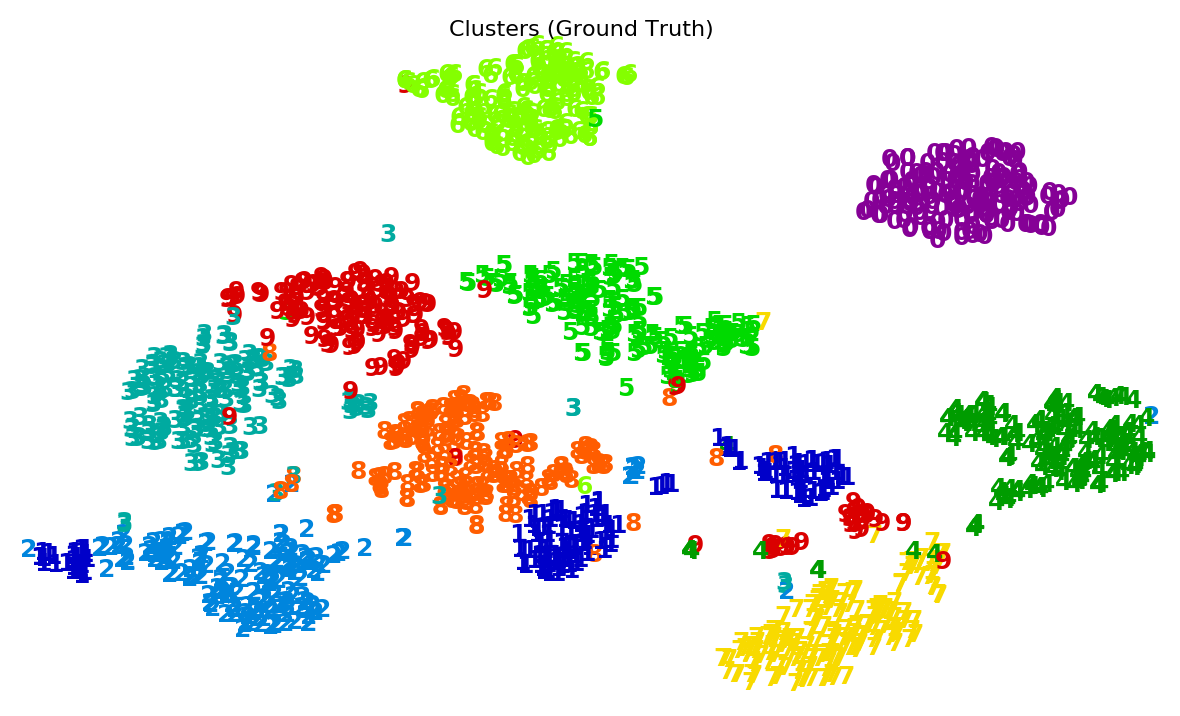

In [31]:
#Run the K-means algorithm
labels, s_coeff = kmeans_cl(tdigits_data,digits_labels,n_digits)

#Get the similar cluster and similar digit pairs
getnearestclusters(tdigits_data,digits_labels,labels)

#### Nearest Digit Pairs (Spectral)

Spectral Clustering:
Input Matrix:  (1797, 2) 

Time Consumed: 	0.58s
Homogeneity: 0.845
Completeness: 0.863
V-measure: 0.854
Adjusted Rand Index: 0.788
Adjusted Mutual Information: 0.844
Silhouette Coefficient: 0.575


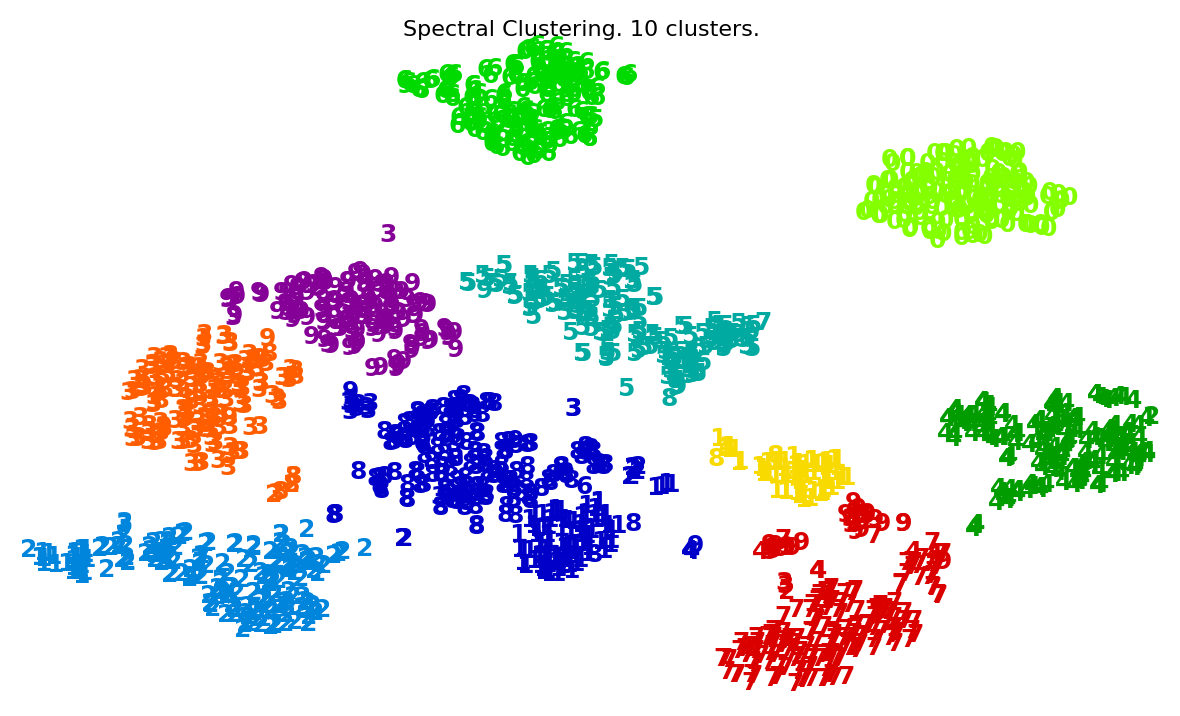


Cluster Digit Mapping:
Digit No.:  0 , Cluster:  6.0 , Number Distribution:  {6.0: 178}
Digit No.:  1 , Cluster:  1.0 , Number Distribution:  {1.0: 93, 2.0: 27, 7.0: 62}
Digit No.:  2 , Cluster:  2.0 , Number Distribution:  {1.0: 9, 2.0: 164, 4.0: 1, 8.0: 2, 9.0: 1}
Digit No.:  3 , Cluster:  8.0 , Number Distribution:  {0.0: 2, 1.0: 13, 2.0: 2, 8.0: 164, 9.0: 2}
Digit No.:  4 , Cluster:  4.0 , Number Distribution:  {1.0: 3, 4.0: 172, 7.0: 1, 9.0: 5}
Digit No.:  5 , Cluster:  3.0 , Number Distribution:  {0.0: 1, 3.0: 180, 5.0: 1}
Digit No.:  6 , Cluster:  5.0 , Number Distribution:  {1.0: 1, 5.0: 180}
Digit No.:  7 , Cluster:  9.0 , Number Distribution:  {3.0: 1, 9.0: 178}
Digit No.:  8 , Cluster:  1.0 , Number Distribution:  {1.0: 167, 3.0: 1, 7.0: 2, 8.0: 4}
Digit No.:  9 , Cluster:  0.0 , Number Distribution:  {0.0: 140, 1.0: 4, 3.0: 3, 5.0: 1, 8.0: 2, 9.0: 30}

Most Similar Digit Pairs: 
 [[  1.     8.     0.  ]
 [  3.     9.    44.7 ]
 [  5.     9.    70.4 ]
 [  2.     3.   104.92

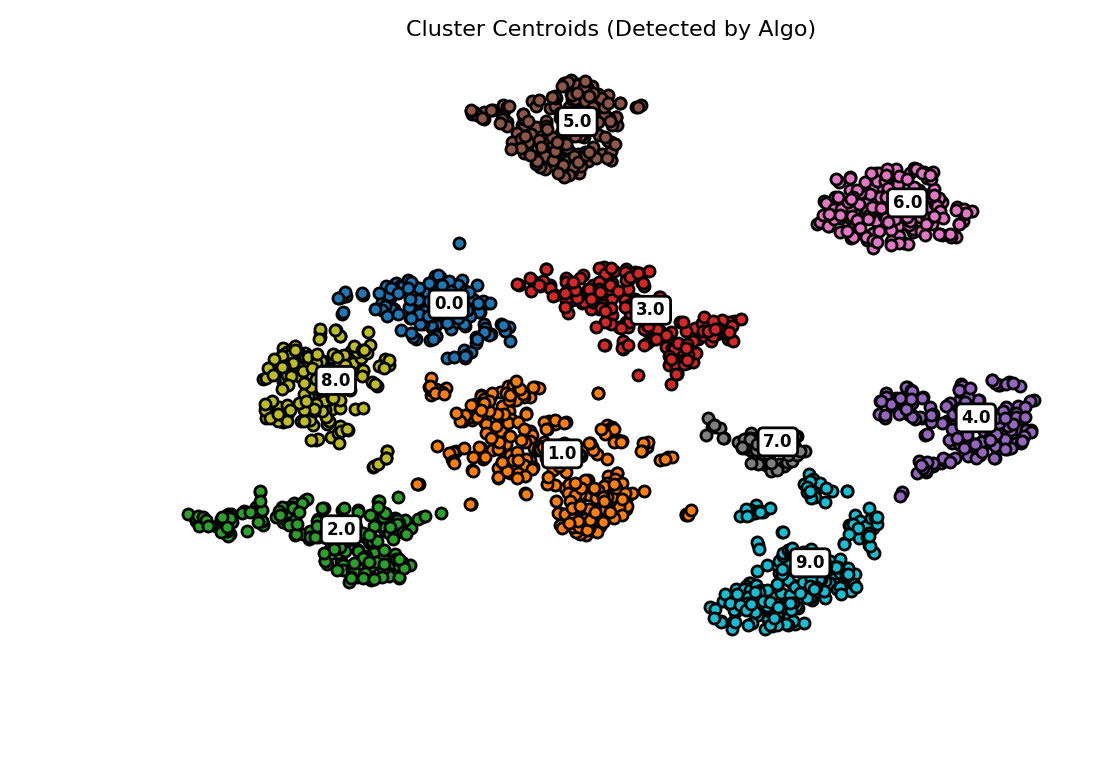

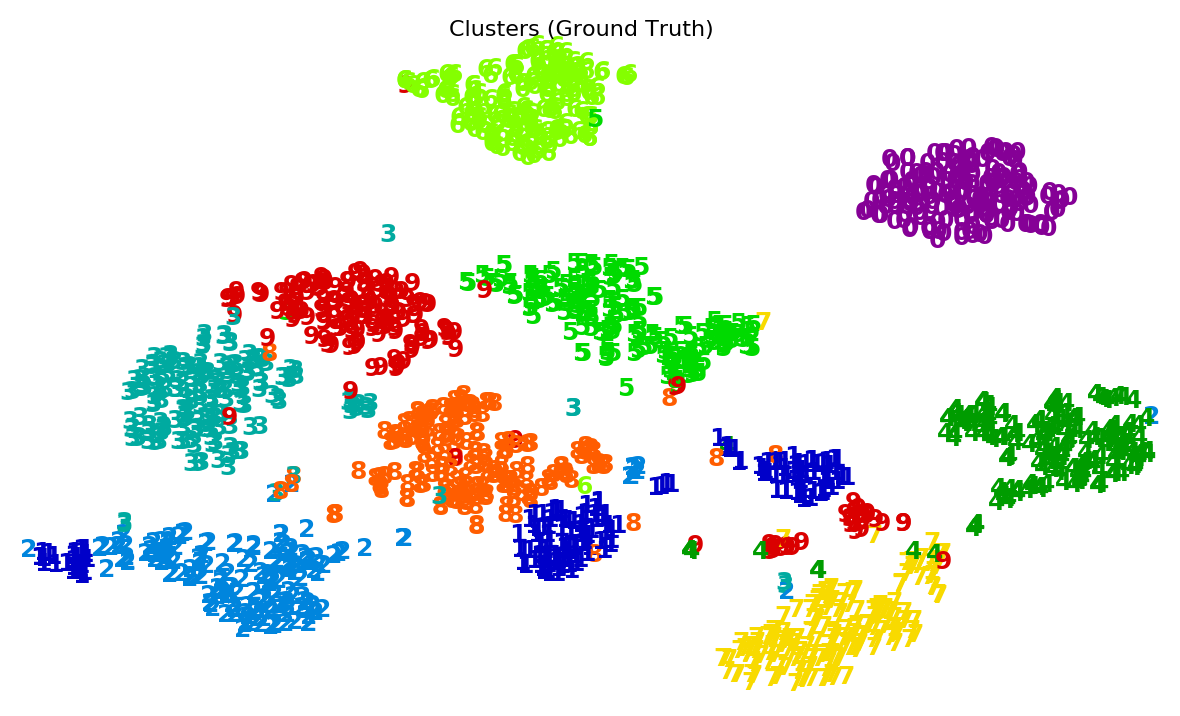

In [32]:
#Run the Spectral algorithm
labels, s_coeff = spec_cl(tdigits_data, digits_labels, n_digits, 15)

#Get the similar cluster and similar digit pairs
getnearestclusters(tdigits_data,digits_labels,labels)